In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from SPHERE.preprocess import *
from SPHERE.SPHERE import *
from SPHERE.utils import *
import numpy as np
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
random_seed = 2022
fix_seed(random_seed)

## MISAR-seq

In [ ]:
datasets = ['./E11_S1.h5ad',
            './E13_S1.h5ad',
            './E15_S1.h5ad',
            './E18_S1.h5ad',]
adata_list = [sc.read_h5ad(dataset) if isinstance(dataset, str) else dataset for dataset in datasets]
slice_name_list = ['E11_0-S1', 'E13_5-S1', 'E15_5-S1', 'E18_5-S1']

import anndata as ad
adata = ad.concat(adata_list, label="slice_name", keys=slice_name_list)
print(adata)

AnnData object with n_obs × n_vars = 7118 × 191034
    obs: 'x', 'idx', 'idy', 'region', 'slice_name'
    obsm: 'spatial'


In [5]:
adata.X[adata.X.nonzero()] = 1
adata.var_names_make_unique()
sc.pp.filter_genes(adata, min_cells=int(0.03 * adata.shape[0]))
lsi(adata, use_highly_variable=False, n_components=101)
adata.obsm['feat'] = adata.obsm['X_lsi'].copy()

In [ ]:
adata = construct_neighbor_graph_inte(adata, slice_name_list)

In [7]:
batch_categories = np.unique(adata.obs['slice_name'])
batch_to_index = {batch: idx for idx, batch in enumerate(batch_categories)}
batch_indices = adata.obs['slice_name'].map(batch_to_index).values
num_batches = len(batch_categories)
batch_labels = np.eye(num_batches)[batch_indices]

In [8]:
model = SPHERE(adata, device=device, learning_rate=0.001, epochs=700, dim_hid=64, 
               integrate=True, batch_label=batch_labels,slice_name_list = slice_name_list, lambda_fea_recon=0.8,lambda_spa_recon=0.1,lambda_recon_pre=5,lambda_con_pre=12,
               lambda_recon=4,lambda_con=10,lambda_align=8,lambda_latent=5)


/home/yuzhuohan/workspace/ATAC/our/code_rep/SPHERE/preprocess.py:148: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [ ]:
output = model.train_inte()
adata.obsm['latent'] = output['latent']
adata.obsm['latent'] = pca(adata, use_reps='latent', n_comps=20)
sc.pp.neighbors(adata, use_rep='latent', n_neighbors=30)
sc.tl.umap(adata)

100%|██████████| 700/700 [00:56<00:00, 12.49it/s]


Model training finished!



/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=16, covariance_type='tied', random_state=1234)
y = gm.fit_predict(adata.obsm['latent'], y=None)
adata.obs["leiden"] = pd.Series(y, index=adata.obs.index, dtype='category')

In [22]:
from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(adata.obs['leiden'], adata.obs['region']), 2)
NMI = np.round(metrics.normalized_mutual_info_score(adata.obs['leiden'], adata.obs['region']), 2)
HS = np.round(metrics.homogeneity_score(adata.obs['leiden'], adata.obs['region']), 2)
print(NMI)
print(ARI)
print(HS)

0.52
0.29
0.51


/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0, 0.5, '')

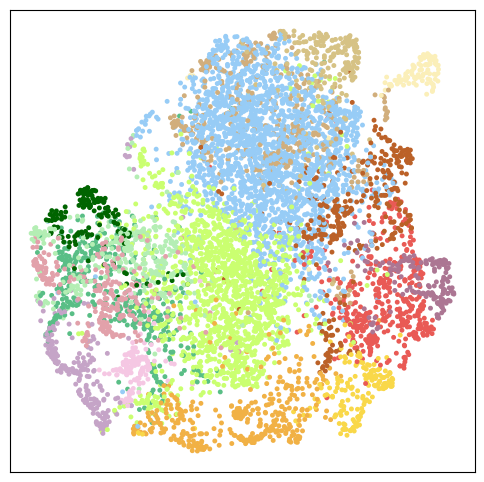

In [23]:
# domain
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)
plot_color = [
  "#D1AE7C", "#E2A1AA", "#F1B145", "#E95A55", "#F5C7E3", "#BB6128",
  "#97CCF6", "#006400", "#D6C285", "#AC7693", "#C5A4C7", "#F9D849",
  "#FBEFB9", "#B4EEB4", "#59BE86", "#CAFF70"
]
leiden_categories = [str(i) for i in range(16)]  
leiden_color_map = dict(zip(leiden_categories, plot_color))

fig, ax = plt.subplots()
sc.pl.umap(
    adata, 
    color=["leiden"],
    s=50,
    show=False,
    palette=plot_color,
    legend_loc=None,
    ax=ax
)

ax.set_title("")  
ax.set_xlabel("")  
ax.set_ylabel("")

/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0, 0.5, '')

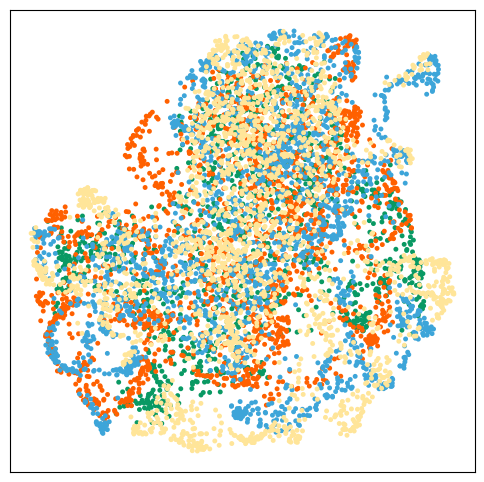

In [ ]:
# batch
plt.rcParams["figure.figsize"] = (6, 6)
plot_color=["#099963","#FF6000","#3DA5D9","#FFE599"]

fig, ax = plt.subplots()
sc.pl.umap(
    adata, 
    color=["slice_name"],
    s=50,
    show=False,
    palette=plot_color,
    legend_loc=None,
    ax=ax
)

ax.set_title("")  
ax.set_xlabel("")  
ax.set_ylabel("")

In [25]:
slice_name_list = ['E11_0-S1', 'E13_5-S1', 'E15_5-S1', 'E18_5-S1']
plot_color = [
  "#D1AE7C", "#E2A1AA", "#F1B145", "#E95A55", "#F5C7E3", "#BB6128",
  "#97CCF6", "#006400", "#D6C285", "#AC7693", "#C5A4C7", "#F9D849",
  "#FBEFB9", "#B4EEB4", "#59BE86", "#CAFF70"
]
leiden_categories = [str(i) for i in range(16)]  
leiden_color_map = dict(zip(leiden_categories, plot_color))

## E11.0

/tmp/ipykernel_3498340/1159564634.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_sub.uns['leiden_colors'] = sub_colors


0.46
0.4
0.48


/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0, 0.5, '')

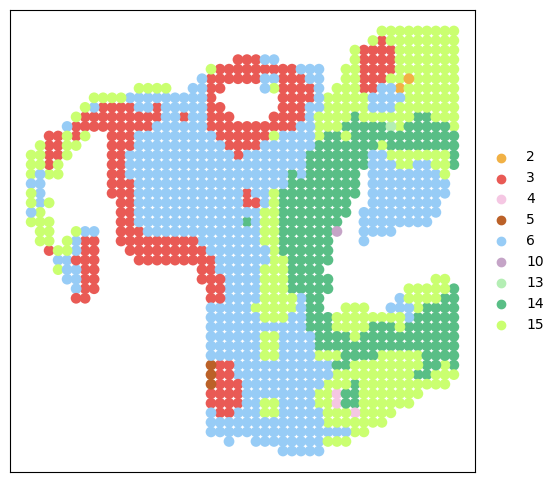

In [ ]:
adata_sub = adata[adata.obs['slice_name']==slice_name_list[0]]
sub_leiden_categories = adata_sub.obs['leiden'].cat.categories
sub_colors = [leiden_color_map[str(cat)] for cat in sub_leiden_categories]
adata_sub.uns['leiden_colors'] = sub_colors

from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(adata_sub.obs['leiden'], adata_sub.obs['region']), 2)
NMI = np.round(metrics.normalized_mutual_info_score(adata_sub.obs['leiden'], adata_sub.obs['region']), 2)
HS = np.round(metrics.homogeneity_score(adata_sub.obs['leiden'], adata_sub.obs['region']), 2)
print(NMI)
print(ARI)
print(HS)

adata_sub.obsm['spatial'][:, 1] = -1*adata_sub.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (6, 6)
fig, ax = plt.subplots()
sc.pl.embedding(
    adata_sub, 
    basis="spatial",
    color="leiden",
    s=240,
    show=False,
    ax=ax
)
ax.set_title("") 
ax.set_xlabel("")  
ax.set_ylabel("")  

## E13.5

0.48
0.28
0.45


/tmp/ipykernel_3498340/2853042286.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_sub.uns['leiden_colors'] = sub_colors
/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0, 0.5, '')

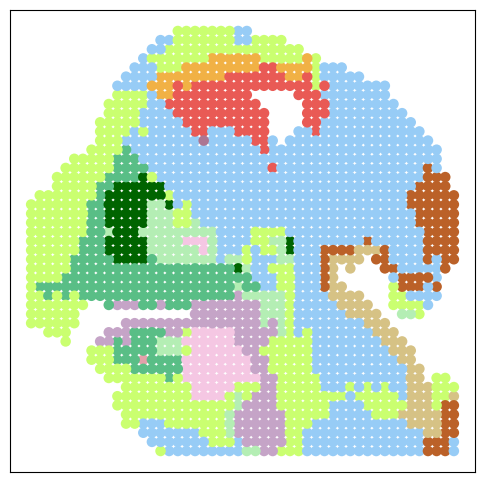

In [27]:
adata_sub = adata[adata.obs['slice_name']==slice_name_list[1]]
sub_leiden_categories = adata_sub.obs['leiden'].cat.categories
sub_colors = [leiden_color_map[str(cat)] for cat in sub_leiden_categories]
adata_sub.uns['leiden_colors'] = sub_colors

from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(adata_sub.obs['leiden'], adata_sub.obs['region']), 2)
NMI = np.round(metrics.normalized_mutual_info_score(adata_sub.obs['leiden'], adata_sub.obs['region']), 2)
HS = np.round(metrics.homogeneity_score(adata_sub.obs['leiden'], adata_sub.obs['region']), 2)
print(NMI)
print(ARI)
print(HS)

adata_sub.obsm['spatial'][:, 1] = -1*adata_sub.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (6, 6)
fig, ax = plt.subplots()
sc.pl.embedding(
    adata_sub, 
    basis="spatial",
    color="leiden",
    s=230,
    show=False,
    legend_loc=None,
    ax=ax
)
ax.set_title("")  
ax.set_xlabel("") 
ax.set_ylabel("")  

## E15.5

/tmp/ipykernel_3498340/2209927322.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_sub.uns['leiden_colors'] = sub_colors


0.59
0.39
0.54


/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0, 0.5, '')

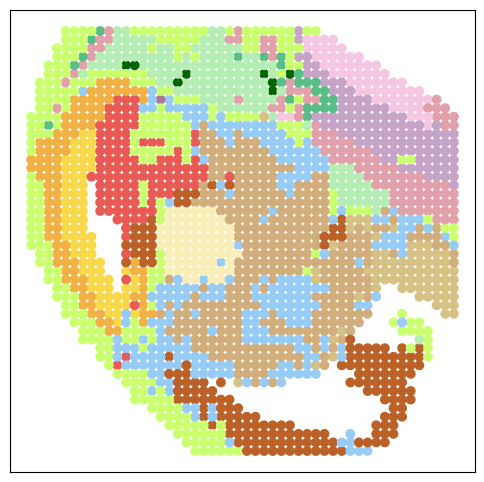

In [28]:
adata_sub = adata[adata.obs['slice_name']==slice_name_list[2]]
sub_leiden_categories = adata_sub.obs['leiden'].cat.categories
sub_colors = [leiden_color_map[str(cat)] for cat in sub_leiden_categories]
adata_sub.uns['leiden_colors'] = sub_colors

from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(adata_sub.obs['leiden'], adata_sub.obs['region']), 2)
NMI = np.round(metrics.normalized_mutual_info_score(adata_sub.obs['leiden'], adata_sub.obs['region']), 2)
HS = np.round(metrics.homogeneity_score(adata_sub.obs['leiden'], adata_sub.obs['region']), 2)
print(NMI)
print(ARI)
print(HS)

adata_sub.obsm['spatial'][:, 1] = -1*adata_sub.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (6, 6)
fig, ax = plt.subplots()
sc.pl.embedding(
    adata_sub, 
    basis="spatial",
    color="leiden",
    s=200,
    show=False,
    legend_loc=None,
    ax=ax
)
ax.set_title("") 
ax.set_xlabel("")  
ax.set_ylabel("")  

## E18.5

/tmp/ipykernel_3498340/855274477.py:4: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_sub.uns['leiden_colors'] = sub_colors


0.65
0.57
0.66


/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


Text(0, 0.5, '')

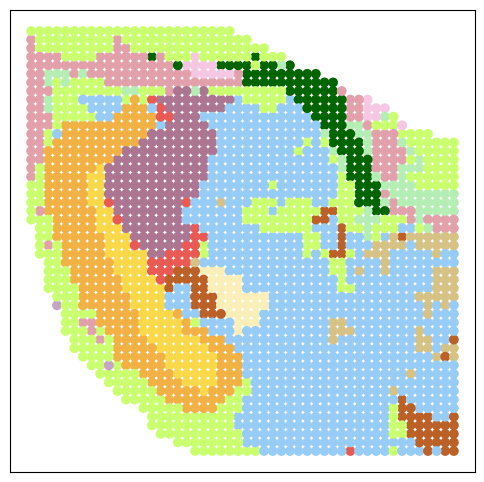

In [29]:
adata_sub = adata[adata.obs['slice_name']==slice_name_list[3]]
sub_leiden_categories = adata_sub.obs['leiden'].cat.categories
sub_colors = [leiden_color_map[str(cat)] for cat in sub_leiden_categories]
adata_sub.uns['leiden_colors'] = sub_colors

from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(adata_sub.obs['leiden'], adata_sub.obs['region']), 2)
NMI = np.round(metrics.normalized_mutual_info_score(adata_sub.obs['leiden'], adata_sub.obs['region']), 2)
HS = np.round(metrics.homogeneity_score(adata_sub.obs['leiden'], adata_sub.obs['region']), 2)
print(NMI)
print(ARI)
print(HS)

adata_sub.obsm['spatial'][:, 1] = -1*adata_sub.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (6, 6)
fig, ax = plt.subplots()
sc.pl.embedding(
    adata_sub, 
    basis="spatial",
    color="leiden",
    s=200,
    show=False,
    legend_loc=None,
    ax=ax
)
ax.set_title("") 
ax.set_xlabel("")  
ax.set_ylabel("")  